In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
import tensorflow as tf

from ssd import SSD300
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility
from utils import read_input

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

Using TensorFlow backend.


In [2]:
# constants
NUM_CLASSES = 20
input_shape = (300, 300, 3)

# read input dataset
train, val = read_input.read_input(img_shape=input_shape[:2], num_cls=NUM_CLASSES)
t_img_path, t_label, t_bbox = train
v_img_path, v_label, v_bbox = val

In [3]:
# len of train and val
num_train = len(t_label)
num_val = len(v_label)

priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))

# note here `+1` means background class
# becuase in BBoxUtility, it use array value to decide procedure.
bbox_util = BBoxUtility(NUM_CLASSES+1, priors)

# generate input sets
batch_size = 16

# some optional images processing coefficients
saturation_var=0.5
brightness_var=0.5
contrast_var=0.5
lighting_std=0.5
hflip_prob=0.5
vflip_prob=0.5
do_crop=True
crop_area_range=[0.75, 1.0]
aspect_ratio_range=[3./4., 4./3.]

## Generate dataflow
1. shuffle datasets
2. read images and resize to input shape and transform into dtype as float32
3. shuffle again
4. do following images processing
 - gray scale
 - saturation (飽和) { color jitter }
 - brightness        { color jitter }
 - contrast          { color jitter }
 - crop (optinal)
 - lighting
 - horizontal flip
 - vertical flip
5. store as array

#### Go!

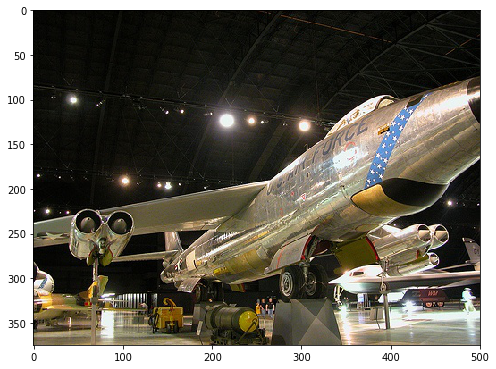

In [4]:
# let's use one image for testing
image_size = input_shape[:2]
img = imread(t_img_path[0])
plt.imshow(img)
img = imresize(img, image_size).astype('float32')

## Let's implement images process first
1. color jitter:
    - grayscale
    - saturation
    - brightness
    - contrast
2. normal action:
    - lighting
    - horizontal flip
    - vertical flip
    - random crop

In [5]:
# processing list
color_jitter = []

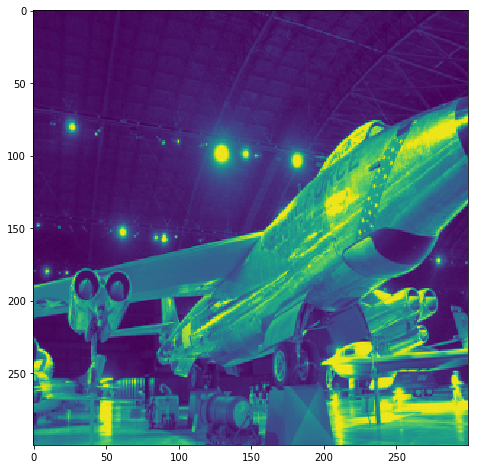

In [6]:
def grayscale(rgb):
    return rgb.dot([0.299, 0.587, 0.114])
plt.imshow(grayscale(img))

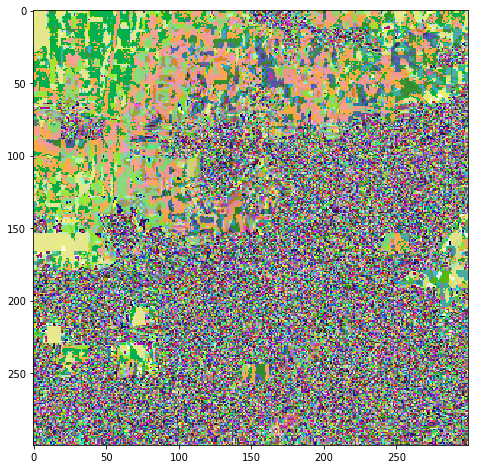

In [7]:
def saturation(rgb):
    gs = grayscale(rgb)
    alpha = 2 * np.random.random() * saturation_var
    alpha += 1 - saturation_var
    rgb = rgb * alpha + (1-alpha) * gs[:, :, None]
    return np.clip(rgb, 0, 255)
plt.imshow(saturation(img))
color_jitter.append(saturation)

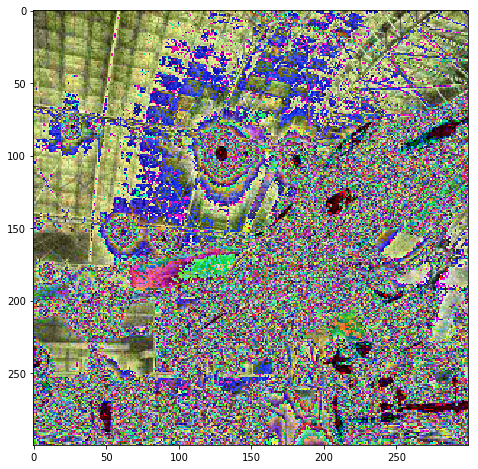

In [8]:
def brightness(rgb):
    alpha = 2 * np.random.random() * brightness_var
    alpha += 1 - saturation_var
    rgb = rgb * alpha
    return np.clip(rgb, 0, 255)
plt.imshow(brightness(img))
color_jitter.append(brightness)

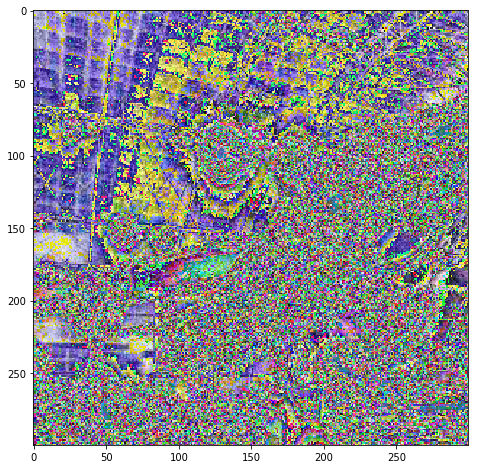

In [9]:
def contrast(rgb):
    gs = grayscale(rgb).mean() * np.ones_like(rgb)
    alpha = 2 * np.random.random() * contrast_var
    alpha += 1 - contrast_var
    rgb = rgb * alpha + (1-alpha) * gs
    return np.clip(rgb, 0, 255)
plt.imshow(contrast(img))
color_jitter.append(contrast)

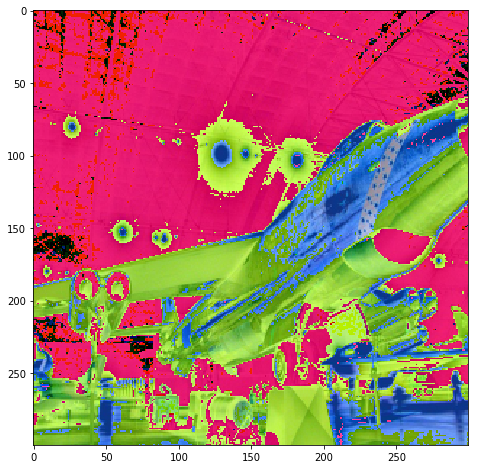

In [10]:
def lighting(img):
    cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
    eigval, eigvec = np.linalg.eigh(cov)
    noise = np.random.randn(3) * lighting_std
    noise = eigvec.dot(eigval * noise) * 255
    img += noise
    return np.clip(img, 0, 255)
plt.imshow(lighting(img))

In [11]:
def horizontal_flip(img, y):
    y = np.array(y)
    if np.random.random() < hflip_prob:
        img = img[:,::-1]
        y[:, [0, 2]] = 1 - y[:, [2, 0]]
    return img, y
# tpimg, _ = horizontal_flip(img, t_bbox[0])
# plt.imshow(tpimg)

In [12]:
def vertical_flip(img, y):
    y = np.array(y)
    if np.random.random() < vertical_flip:
        img = img[::-1]
        y[:,[1, 3]] = 1 - y[:, [3, 1]]
    return img, y
# tpimg, _ = vertical_flip(img, t_bbox[0])
# plt.imshow(tpimg)

In [13]:
def random_sized_crop(img, targets):
    # area info
    img_w = img.shape[1]
    img_h = img.shape[0]
    img_area = img_w * img_h
    
    # calculate scale for image cropping
    random_scale = np.random.random()
    random_scale *= (crop_area_range[1] - crop_area_range[0])
    random_scale += crop_area_range[0]
    target_area = random_scale * img_area
    
    # calculate ratio for ceiling
    random_ratio = np.random.random()
    random_ratio *= (aspect_ratio_range[1] - aspect_ratio_range[0])
    random_ratio += aspect_ratio_range[0]
    
    # get minimist width and height between original and processed.
    w = np.round(np.sqrt(target_area * random_ratio))
    h = np.round(np.sqrt(target_area / random_ratio))
    if np.random.random() < 0.5:
        w, h = h, w
    w = min(w, img_w)
    w_rel = w / img_w
    w = int(w)
    h = min(h, img_h)
    h_rel = h / img_h
    h = int(h)
    
    x = np.random.random() * (img_w - w)
    x_rel = x / img_w
    x = int(x)
    y = np.random.random() * (img_h - h)
    y_rel = y / img_h
    y = int(y)
    # crop
    img = img[y:y+h, x:x+w]
    new_targets = []
    # recalculate bonding box
    for box in targets:
        cx = 0.5 * (box[0] + box[2])
        cy = 0.5 * (box[1] + box[3])
        if (x_rel < cx < x_rel + w_rel and
            y_rel < cy < y_rel + h_rel):
            xmin = (box[0] - x_rel) / w_rel
            ymin = (box[1] - y_rel) / h_rel
            xmax = (box[2] - x_rel) / w_rel
            ymax = (box[3] - y_rel) / h_rel
            xmin = max(0, xmin)
            ymin = max(0, ymin)
            xmax = min(1, xmax)
            ymax = min(1, ymax)
            box[:4] = [xmin, ymin, xmax, ymax]
            new_targets.append(box)
    new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
    return img, new_targets

In [14]:
# generate data preprocess_img_array, and data shape with (batch_size, ground-truth-box{xmin, ymin, xmax, ymax} + NUM_CLASSES) 
def generate(train=True):
    while True:
        if train:
            datazipped = zip(t_img_path, t_label, t_bbox)
            shuffle(datazipped)
        else:
            datazipped = zip(v_img_path, v_label, v_bbox)
            shuffle(datazipped)
        paths, labels, bboxs = zip(*datazipped)
        inputs = []
        targets = []
        for i in range(len(paths)):
            img = imread(paths[i]).astype('float32')
            bbox = np.array(bboxs[i]).copy()
            label = np.array(labels[i]).copy()
            if train and do_crop:
                img, bbox = random_sized_crop(img, bbox)
            img = imresize(img, image_size).astype('float32')
            if train:
                shuffle(color_jitter)
                for jitter in color_jitter:
                    img = jitter(img)
                if lighting_std:
                    img = lighting(img)
                if hflip_prob > 0:
                    img, bbox = horizontal_flip(img, bbox)
                if vflip_prob > 0:
                    img, bbox = vertical_flip(img, bbox)
            label = np.tile(label, (bbox.shape[0], 1))
            y = np.concatenate((bbox, label), axis=1)
            y = bbox_util.assign_boxes(y)
            inputs.append(img)
            targets.append(y)
            if len(targets) == batch_size:
                tmp_inp = np.array(inputs)
                tmp_targets = np.array(targets)
                inputs = []
                targets = []
                yield preprocess_input(tmp_inp), tmp_targets

## Train test

In [21]:
model = SSD300(input_shape, num_classes=NUM_CLASSES+1)
model.load_weights('checkpoints/weights.29-5.37.hdf5', by_name=True)

freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
          'conv2_1', 'conv2_2', 'pool2',
          'conv3_1', 'conv3_2', 'conv3_3', 'pool3']

# freeze pre-trained conv
for L in model.layers:
    if L.name in freeze:
        L.trainable = False

# callback
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]

# loss function and optimiser
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES+1, neg_pos_ratio=2.0).compute_loss)

nb_epoch = 30
gen = generate()
genF = generate(False)
history = model.fit_generator(generator=gen, steps_per_epoch=int(len(t_img_path)/batch_size),
                              epochs=nb_epoch, verbose=1, callbacks=callbacks,
                              validation_data=genF, validation_steps=int(len(v_img_path)/batch_size))


Epoch 1/30
219/219 [==============================] - 203s - loss: 2.8732 - val_loss: 5.1818
Epoch 2/30
219/219 [==============================] - 201s - loss: 2.7982 - val_loss: 5.2781
Epoch 3/30
219/219 [==============================] - 201s - loss: 2.6394 - val_loss: 5.4402
Epoch 4/30
219/219 [==============================] - 201s - loss: 2.5233 - val_loss: 5.1895
Epoch 5/30
219/219 [==============================] - 201s - loss: 2.3855 - val_loss: 5.0494
Epoch 6/30
219/219 [==============================] - 201s - loss: 2.3213 - val_loss: 5.1929
Epoch 7/30
219/219 [==============================] - 201s - loss: 2.1629 - val_loss: 5.1628
Epoch 8/30
219/219 [==============================] - 201s - loss: 2.0850 - val_loss: 5.5946
Epoch 9/30
219/219 [==============================] - 201s - loss: 2.0050 - val_loss: 5.5537
Epoch 10/30
219/219 [==============================] - 201s - loss: 1.9484 - val_loss: 5.5524
Epoch 11/30
219/219 [==============================] - 201s - loss: 1

KeyboardInterrupt: 

## Test it

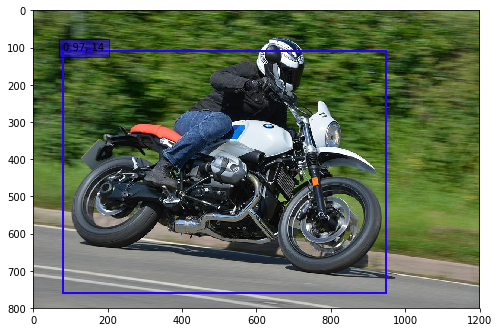

In [26]:
# load model to test with
# model = SSD300(input_shape, num_classes=NUM_CLASSES+1)
# model.load_weights('weights_SSD300.hdf5', by_name=True)
#model.load_weights('checkpoints/weights.03-4.54.hdf5', by_name=True)
inputs = []
images = []

#img_path = './pics/fish-bike.jpg'
#img_path = './pics/my-test-motor.jpg'
img_path = './pics/my-test-motor-man.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
# for imshow usage
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

results = model.predict(inputs, batch_size=1)
results = bbox_util.detection_out(results)

for i, img in enumerate(images):
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]
    
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]
    
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]
    
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    
    plt.imshow(img / 255.)
    currentAxis = plt.gca()
    
    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        
        score = top_conf[i]
        label = int(top_label_indices[i])
        #label_name = voc_classes[label-1]
        display_txt = '{:0.2f}, {}'.format(score, label)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor': color, 'alpha': 0.5})
    
    plt.show()